# Yolov11 Instance Segmentation Model with Custom Data for Tag a Turtle Project - Jupyter Notebook


---

| Author                  | Date        | Version |
|-------------------------|-------------|---------|
| Yasmin Abhrao Kfuri     | 24/06/2025  | 1.0     |



---

## Table of Contents

- [1. Summary](#1)
- [2. Introduction: Computer Vision in Tag a Turtle Project](#2)
- [3. Why Segmentation Matters](#3)
- [4. Instance Segmentation with YOLOv11 pipeline](#4)
- [4.1. Dataset Preparation](#41)
- [4.2. Enviroment Setup](#42)
- [4.2.1. Mitigating GPU Limitations in Google Colab](#421)
- [4.3. Model Training](#43)
- [4.3.1. Model Selection: Why YOLOv11?](#431)
- [4.4. Data Transformation & Normalization](#44)
- [4.4.1 Normalization](#441)
- [4.4.2. Format Conversion](#442)
- [4.5. Model Training](#45)
- [4.6. Downloading the model](#46)
- [5. Model Evaluation](#5)
- [5.1. Conclusion](#51)


## 1. Summary <a name="1"></a>

This project focuses on detecting and segmenting turtles, including their heads and flippers, in underwater images using a deep learning approach. By leveraging the **YOLOv11** segmentation model and a labeled dataset from Roboflow, a model was trained, capable of identifying key turtle features. The project involved data preprocessing, training, validation, and inference testing in Google Colab.

## 2. Introduction: Computer Vision in Tag a Turtle Project <a name="2"></a>

Computer Vision (CV) is a field of artificial intelligence that trains computers to interpret and process visual information from the world, such as images and videos. It plays a vital role in applications like facial recognition, self-driving cars, medical image analysis, and wildlife monitoring.

CV pipelines typically include tasks like:

* Image Classification: Identifying the object category in an image

* Object Detection: Locating objects in an image with bounding boxes

* Segmentation: Delineating exact object shapes pixel-by-pixel (more detailed than detection)

* Deep learning frameworks and architectures (e.g., YOLO, Mask R-CNN, U-Net) make these tasks scalable and accurate.

## 3. Why Segmentation Matters <a name="3"></a>

Segmentation provides pixel-level understanding of objects in images. For tasks like turtle monitoring and conservation:

* It's important to identify exact boundaries of the turtle

* Differentiating between the flippers, head, and shell supports biometric analysis

* It's critical for robust population tracking and behavioral research

Segmentation is more precise than detection and is especially valuable in scientific, medical, and ecological applications where object boundaries contain vital information.

## 4. Instance Segmentation with YOLOv11 pipeline <a name="4"></a>

### 4.1. Dataset Preparation <a name="41"></a>


* Exported from Roboflow: chosen because it offers high-quality, well-annotated, and well-segmented data with over 5,000 images.

* Initially exported in COCO segmentation format and later converted to YOLOv11 segmentation format for training.

* Contained three classes: turtle, flipper, and head

**What are Classes in Segmentation?**

In segmentation, classes refer to the distinct categories or objects we want the model to recognize and segment. Each pixel in the image is classified into one of these classes. For this project, identifying separate regions (head, flippers, turtle body) helps with fine-grained biological analysis and monitoring.

| Class     | Description                | Example Label |
|-----------|----------------------------|---------------|
| Turtle    | Full turtle body           | `0 x1 y1 x2 y2 ...` |
| Head      | Turtle’s head only         | `1 x1 y1 x2 y2 ...` |
| Flippers  | Turtle’s front/back limbs  | `2 x1 y1 x2 y2 ...` |

The dataset was uploaded manually to Google Drive > data-seg folder.


In [ ]:
from google.colab import drive
import zipfile
import os

# Mount the drive
drive.mount('/content/drive')

# Set paths
zip_path = '/content/drive/MyDrive/data-seg/turtle-segmentation.v2i.coco-segmentation.zip'
extract_path = '/content/turtle_seg'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted to: /content/turtle_seg


### 4.2. Environment setup <a name="42"></a>

* Platform: Google Colab (with GPU enabled)

* Why Colab: Free GPU access for deep learning, flexible environment, easy access to Google Drive. In addition, it's the environment the stakeholder already uses.

* Challenges: GPU availability is limited; runtime sessions reset after 1–3 hours depending on usage. This means the management of the resources should be taken into consideration.

* Training Duration: Training took approximately 5 days due to GPU time constraints and internet speed variations. If using Google PRO, though, 100 units are available per month - which would decrease the time used for training.

**Libraries Used**

| Library       | Purpose                                              |
| ------------- | ---------------------------------------------------- |
| ultralytics   | Main library for YOLOv8/v11 training and inference   |
| supervision   | Visualizing and debugging masks and bounding boxes   |
| PIL           | Image loading and manipulation                       |
| matplotlib    | Plotting and displaying output results               |
| opencv        | Preprocessing images, resizing, and format conversion|

#### 4.2.1. Mitigating GPU Limitations in Google Colab <a name="421"></a>

Google Colab provides free access to GPUs, but with strict usage quotas and session limits (typically 1–3 hours per session for free users). These constraints can interrupt long training sessions. To mitigate this:

* Model Checkpointing: Save model weights periodically using `best.pt` and `last`.pt so training can resume later with `resume=True`.

* Drive Integration: Store all weights, datasets, and configuration files in Google Drive to persist data between sessions.

* Batch Training Strategy: Train in segments (e.g., 20–30 epochs at a time), saving after each batch.

* Use Lower Batch Size: This reduces memory use and can help avoid crashes from memory limits.

* Monitor Runtime Warnings: Colab provides alerts about session time left—use them to proactively save progress.

For critical or long-term projects, it would use be avisable to consider using Colab Pro or migrating to other cloud GPU services (like Kaggle, AWS, or Paperspace) with better session stability.

In [ ]:
!pip install ultralytics --upgrade -q

In [ ]:
import ultralytics
print(ultralytics.__version__)

8.3.156


### 4.3. Model Training <a name="43"></a>

#### 4.3.1 Model Selection: Why YOLOv11? <a name="431"></a>

YOLOv11 is the latest iteration in the YOLO (You Only Look Once) family, focusing on high-speed, accurate object detection and segmentation.

Offers native support for segmentation, real-time performance, and simpler deployment.

Compared to older models (like YOLOv5 or Mask R-CNN), YOLOv11 is:

* More lightweight and faster (suitable for cloud and embedded deployment)

* Includes better transformer-based features for segmentation

* Seamless integration with the ultralytics Python API

It was selected the small variant (yolo11s-seg.pt) due to limited GPU resources in Google Colab and the need for a faster training time. Larger models (e.g., yolo11m or yolo11l) offer higher accuracy but require significantly more memory and time.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11s-seg.pt')  # You can try 'yolo11m-seg.pt' or 'yolo11l-seg.pt' as well

In [ ]:
import os

print("Train:", os.listdir("/content/turtle_seg/train")[:3])
print("Valid:", os.listdir("/content/turtle_seg/valid")[:3])

Train: ['VcdARKlbLh_JPG.rf.b3bc7aa4e998f8229fcbc3c405c0b6b3.jpg', 'KocFMbkfNX_jpg.rf.232690164d5d71ff6d8e3d2e12cacc2f.jpg', 'rbFOSKgVDt_JPG.rf.8d1f1d83e7f7b2649f84d2f0e7c536c4.jpg']
Valid: ['mUdeKWpwMH_JPG.rf.73c71e1a65a1f72d3b85327e326db80d.jpg', 'unZlcsvEUj_JPG.rf.af83a5ed8513f8434a9d3913574a8787.jpg', 'XMbSfBbZUY_JPG.rf.cd5d21849324bd71efdb12805c03447b.jpg']


### 4.4. Data Transformation & Normalization <a name="44"></a>

#### 4.4.1 Normalization <a name="441"></a>

The dataset was unbalanced in terms of training and validation folders. Therefore, we implemented a manual normalization script that:

* Randomly selects 10% of training images.

* Moves these images and corresponding .txt label files to a valid folder.

* Ensures consistency in dataset splits and avoids model overfitting on training-only data.

In [ ]:
import os
import random
import shutil

# Paths
base_path = "/content/turtle_seg"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "valid")

# Create folder valid if it doesnt exist
os.makedirs(val_path, exist_ok=True)

# Gather all images (JPG, JPEG, PNG)
image_files = [f for f in os.listdir(train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Separate 10% of valid images
val_split = int(len(image_files) * 0.1)
val_images = image_files[:val_split]

for img_name in val_images:
    label_name = os.path.splitext(img_name)[0] + ".txt"

    # Move image
    shutil.move(os.path.join(train_path, img_name), os.path.join(val_path, img_name))

    # Move label if exist
    label_path = os.path.join(train_path, label_name)
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(val_path, label_name))


#### 4.4.2. Format Conversion <a name="442"></a>
The dataset was initially exported in COCO Segmentation format, a JSON-based structure widely used for instance segmentation.

For training with YOLOv11, it was converted to YOLOv11 segmentation format, which uses .txt files where each line represents a polygon mask with class ID followed by normalized x,y points.

Conversion was done using a custom script adapted from community tools.

In [ ]:
 from pycocotools.coco import COCO
import os
import json
from tqdm import tqdm

def convert_coco_to_yolo_seg(coco_json_path, output_dir):
    coco = COCO(coco_json_path)
    image_dir = os.path.join(os.path.dirname(coco_json_path), "images")
    os.makedirs(output_dir, exist_ok=True)

    for img in tqdm(coco.imgs.values(), desc="Converting"):
        image_id = img['id']
        file_name = img['file_name']
        label_file = os.path.join(output_dir, os.path.splitext(file_name)[0] + ".txt")
        anns = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

        with open(label_file, "w") as f:
            for ann in anns:
                seg = ann["segmentation"]
                if not seg or type(seg) != list:
                    continue
                category_id = ann["category_id"]
                flat_seg = seg[0]
                w, h = img["width"], img["height"]
                normalized = [str(category_id)] + [f"{flat_seg[i] / w:.6f}" if i % 2 == 0 else f"{flat_seg[i] / h:.6f}" for i in range(len(flat_seg))]
                f.write(" ".join(normalized) + "\n")

In [ ]:
convert_coco_to_yolo_seg(
    coco_json_path="/content/turtle_seg/train/_annotations.coco.json",
    output_dir="/content/turtle_seg/train"
)

convert_coco_to_yolo_seg(
    coco_json_path="/content/turtle_seg/valid/_annotations.coco.json",
    output_dir="/content/turtle_seg/valid"
)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


Converting: 100%|██████████| 6093/6093 [00:02<00:00, 2071.13it/s]


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


Converting: 100%|██████████| 1743/1743 [00:00<00:00, 1877.68it/s]


In [ ]:
check_folder_content("/content/turtle_seg/train")
check_folder_content("/content/turtle_seg/valid")


In [ ]:
import os

def check_folder_content(folder):
    print(f"\n📂 Checking folder: {folder}")
    files = os.listdir(folder)
    images = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
    labels = [f for f in files if f.endswith('.txt')]
    print(f"🖼️ Images: {len(images)}")
    print(f"🏷️ Labels: {len(labels)}")
    if len(images) == 0 or len(labels) == 0:
        print("⚠️ Missing files!")
    return images, labels

train_images, train_labels = check_folder_content("/content/turtle_seg/train")
val_images, val_labels = check_folder_content("/content/turtle_seg/valid")



📂 Checking folder: /content/turtle_seg/train
🖼️ Images: 5484
🏷️ Labels: 6093

📂 Checking folder: /content/turtle_seg/valid
🖼️ Images: 2352
🏷️ Labels: 1743


### 4.5. Model Training <a name="45"></a>

* Model used: YOLOv11 segmentation (yolo11s-seg.pt)

* Training duration: 100 epochs

* Configuration file: A data.yaml file was created to define: the path to the dataset, class names, number of classes (nc)

In [ ]:
data_yaml = """
path: /content/turtle_seg
train: train
val: valid
names:
  - turtle-flipper-head
  - flipper
  - head
  - turtle
nc: 4
"""

with open("/content/turtle_seg/data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ data.yaml created")


✅ data.yaml created


In [ ]:
!cat /content/turtle_seg/data.yaml


path: /content/turtle_seg
train: train
val: valid
names:
  - turtle-flipper-head
  - flipper
  - head
  - turtle
nc: 4


This YAML is essential for training because it tells the model how to interpret the dataset structure.

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s-seg.pt")

model.train(
    data="/content/turtle_seg/data.yaml",
    epochs=100,
    imgsz=640,
    name="yolo11-turtle-retrain",
    project="turtle_segmentation"
)


**IMPORTANT**

Due to limited GPU time in Colab, we implemented a system to resume training using the latest checkpoint (last.pt). This ensured that we didn’t lose progress between GPU sessions.

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/last.pt")  # e.g., "runs/segment/your_run/weights/last.pt"
model.train(
    data="/content/turtle_seg/data.yaml",
    epochs=100,            # Total epochs you want (it resumes from where it stopped)
    resume=True            # Important!
)

### 4.6. Downloading the model <a name="46"></a>



In [ ]:
from google.colab import files
files.download("/content/turtle_segmentation/yolo11-turtle-retrain/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Model Evaluation <a name="5"></a>

The final trained YOLOv11 segmentation model was evaluated using an external image of an underwater turtle that was not part of the training or validation dataset.

Saving img04.jpeg to img04.jpeg


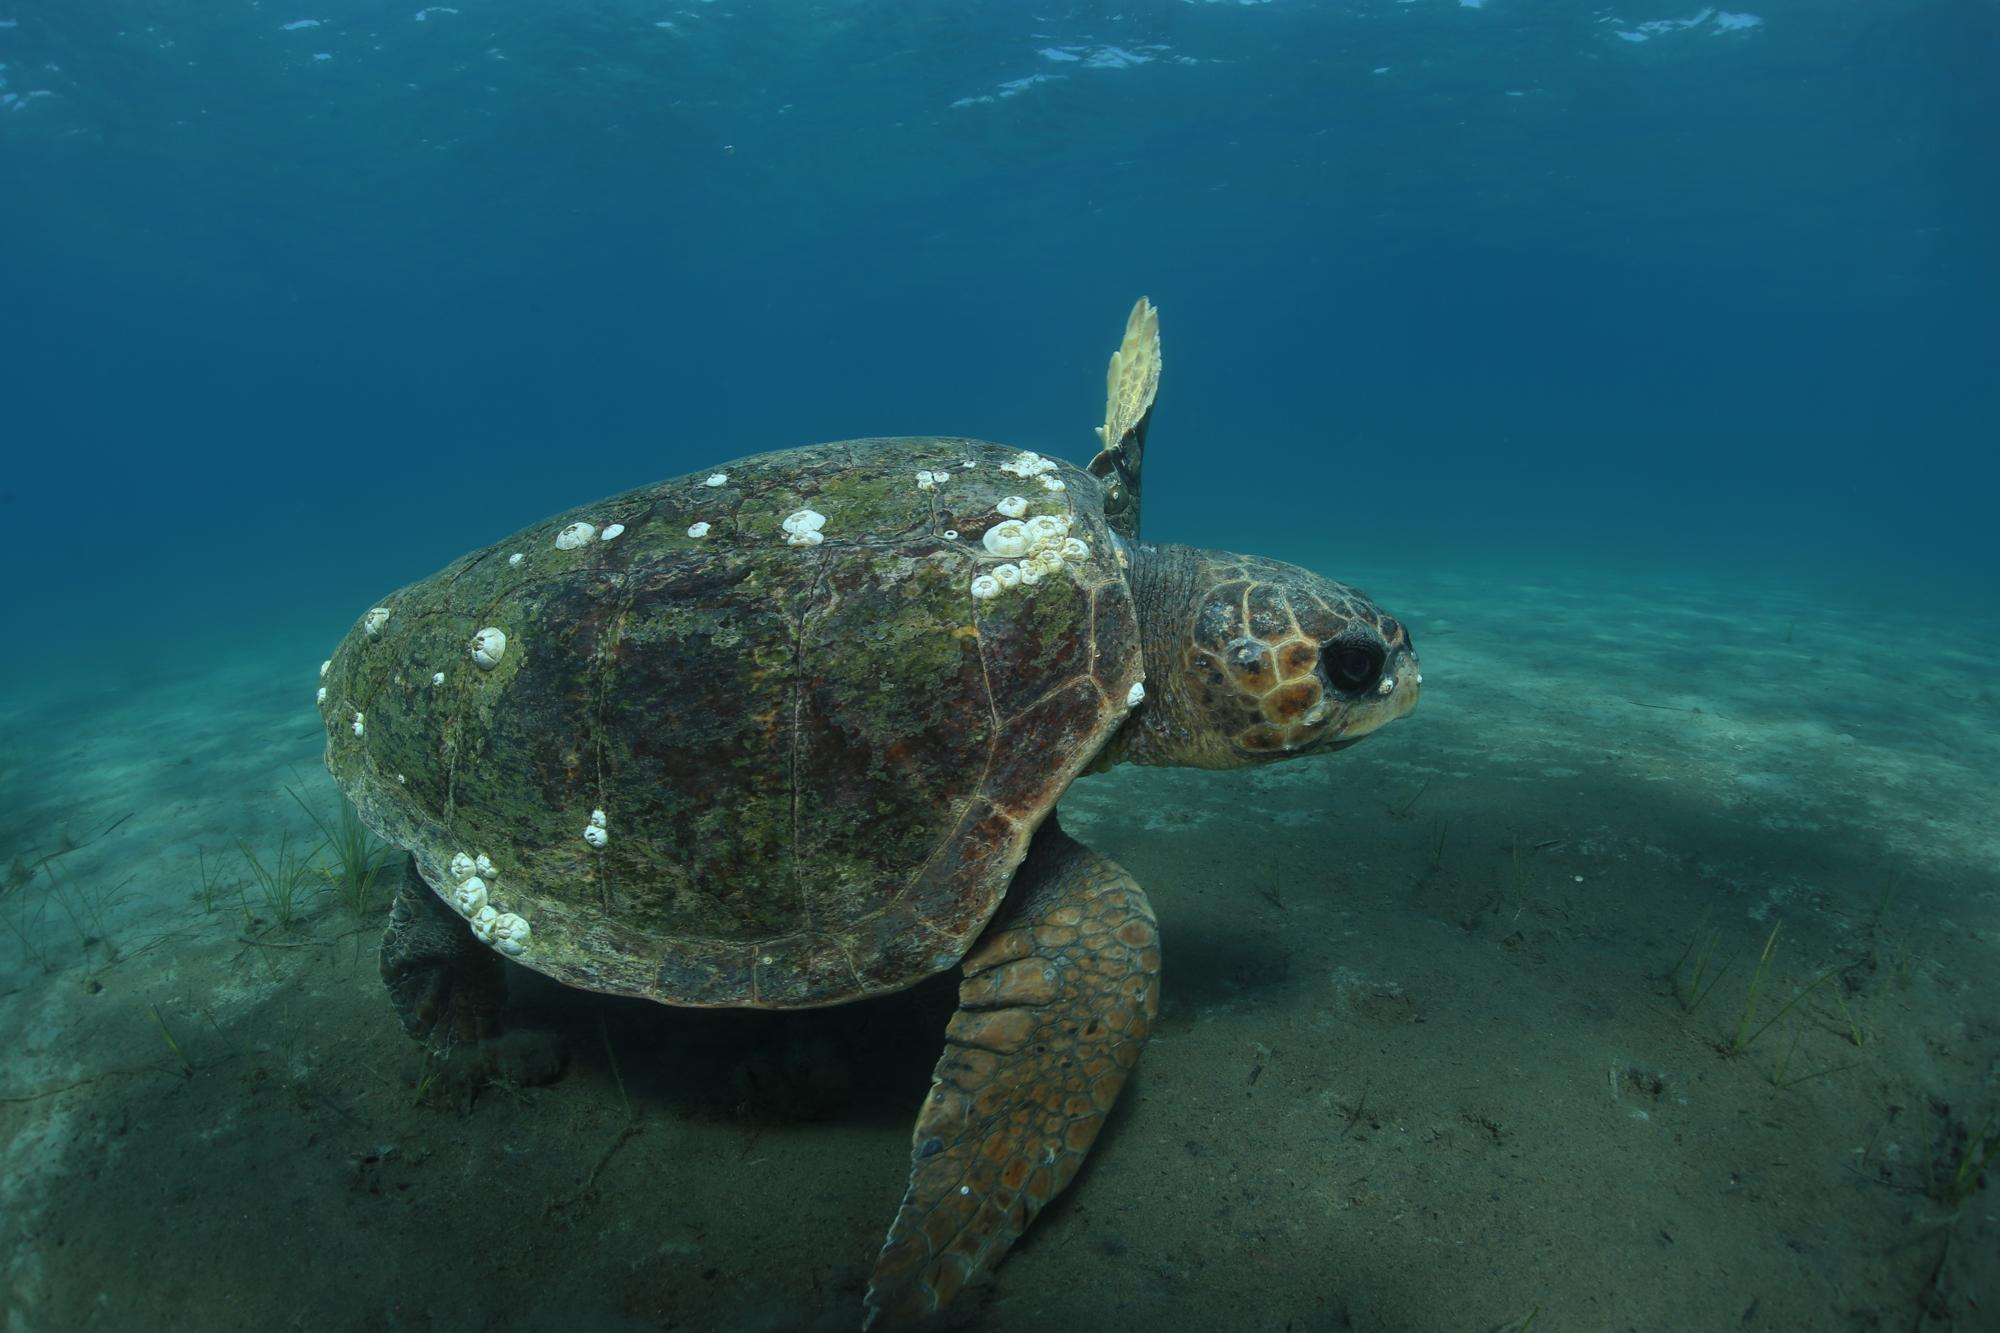

In [ ]:
from google.colab import files
uploaded = files.upload()

from PIL import Image
img_path = list(uploaded.keys())[0]
Image.open(img_path)

Arquivo encontrado: runs/segment/predict/img04.jpg


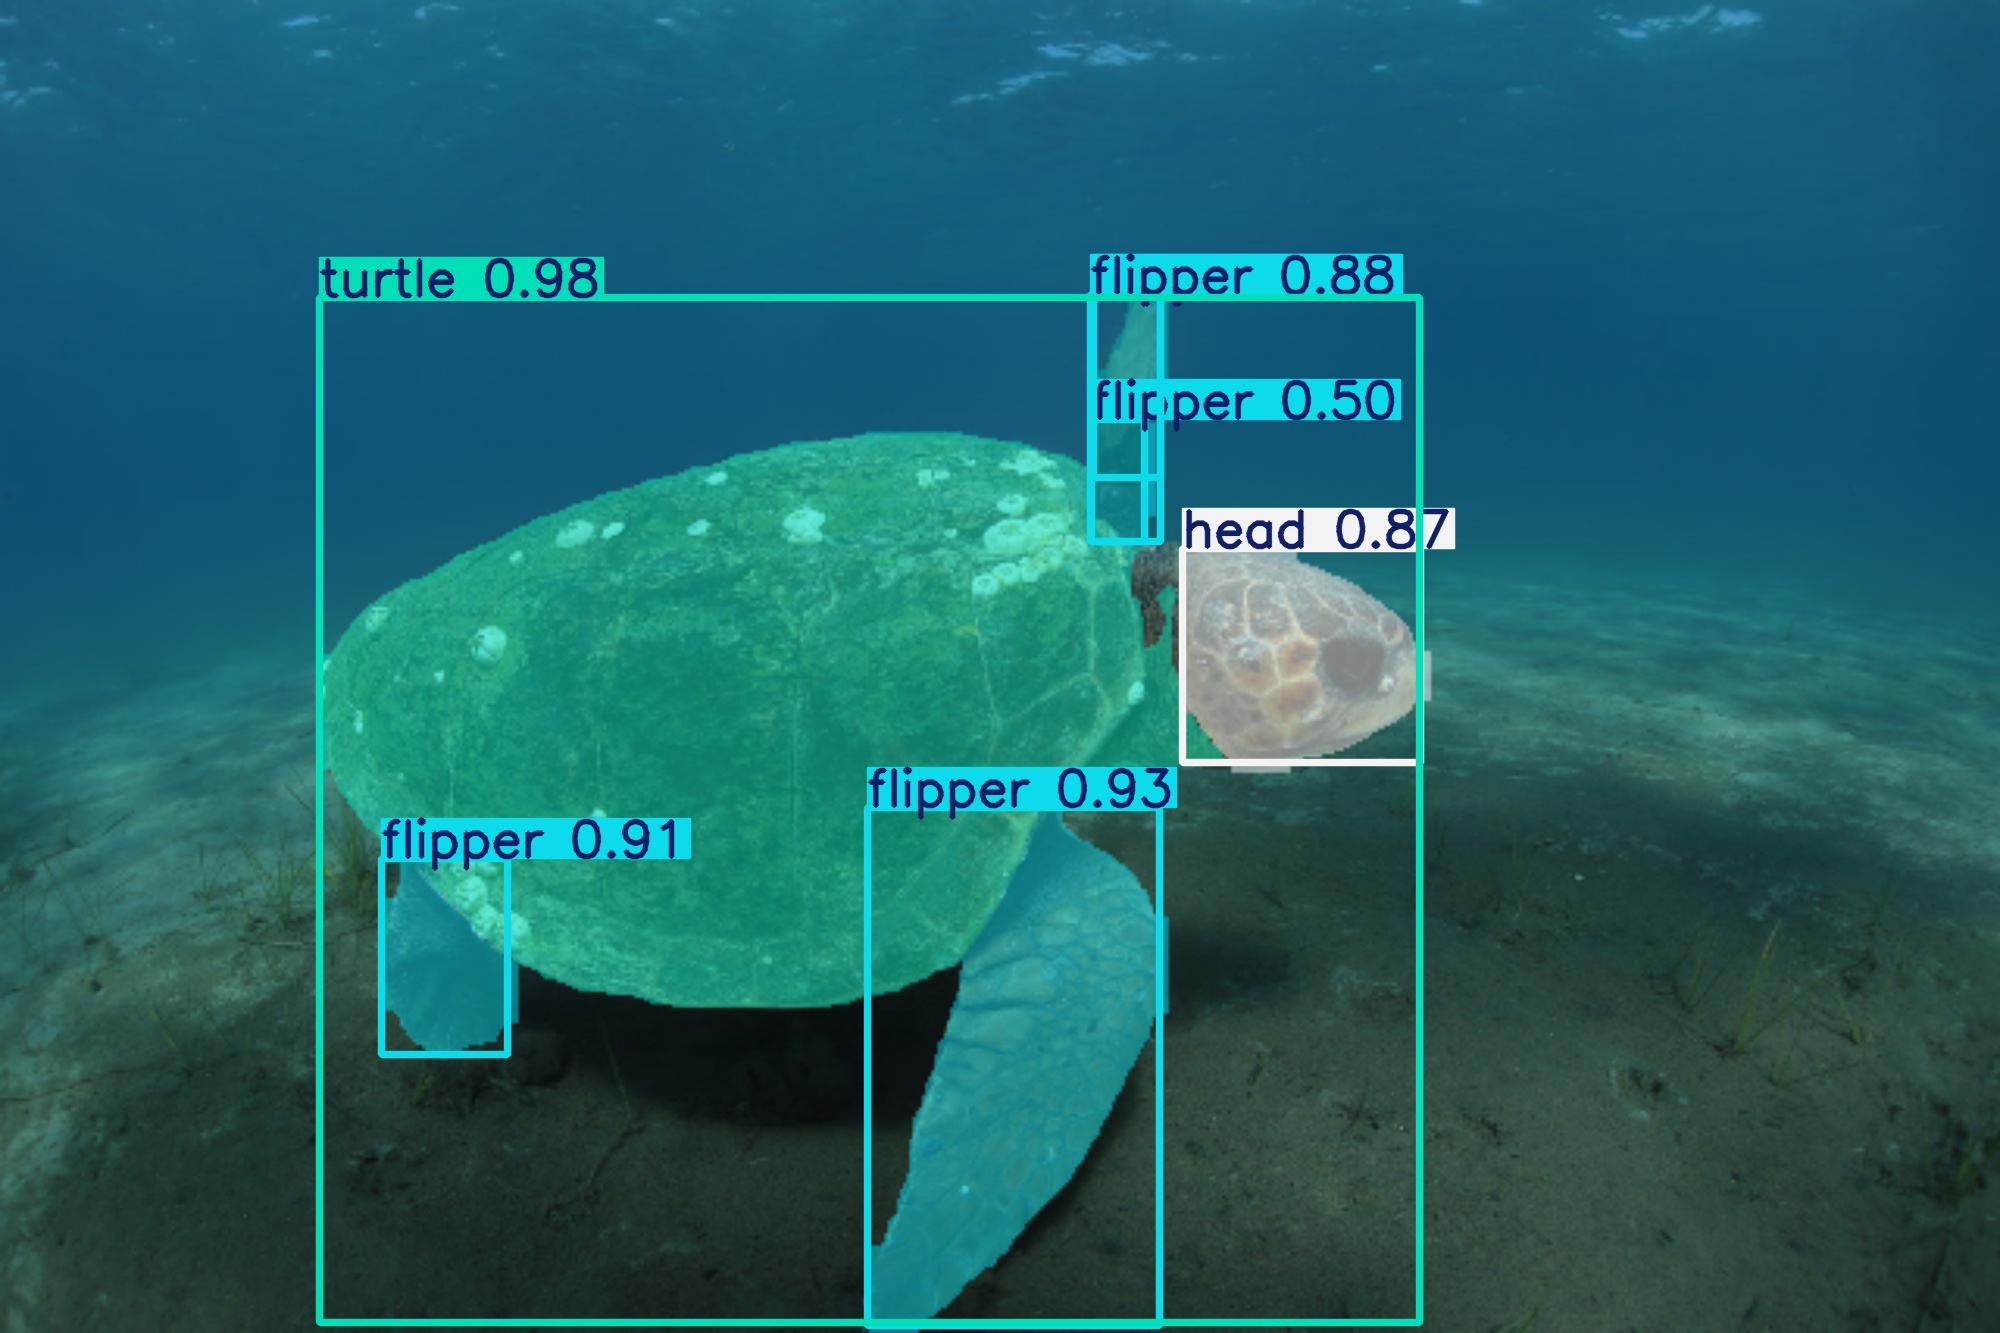

In [ ]:
import os
from glob import glob
from IPython.display import Image as IPyImage, display

# Find the automatically generated file in the results folder
predict_dir = "runs/segment/predict"
predicted_images = glob(os.path.join(predict_dir, "*.jpg"))

# Check for saved files
if predicted_images:
    print(f"Arquivo encontrado: {predicted_images[0]}")
    display(IPyImage(filename=predicted_images[0]))
else:
    print("Nenhuma imagem foi salva em runs/segment/predict")


### 5.1. Conclusion <a name="51"></a>

The model was able to successfully detect and segment the turtle body, its head, and flippers—demonstrating that all three target classes were learned. However, the quality of the segmentation masks, especially around the edges, showed room for improvement. While the classes were correctly identified, some masks lacked smoothness and fine boundary precision, suggesting that further fine-tuning or data augmentation could enhance the model’s performance. Overall, the evaluation confirmed that the model generalized well and met the primary objectives of this segmentation project.
